<a href="https://colab.research.google.com/github/Jesteban247/ML-College/blob/main/Fund_%20ML/Projects/Project_1/Part_2/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
!pip install spotipy
!pip install google-search-results
!pip install beautifulsoup4
!pip install nltk
!pip install torch
!pip install transformers
!pip install plotly

# Import Libraries

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px
from tqdm import tqdm
from google.colab import userdata
nltk.download('stopwords')

# Section 1: Songs

## Spotify API Setup and Fetch Playlist Data

In [ ]:
client_id = userdata.get('client_id')
client_secret = userdata.get('client_secret')
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Fetch songs from a Spotify playlist
playlist_id = "6BFTFkzp4t3tzBkYQqZgrf"
tracks = []

offset = 0
limit = 100

while True:
    playlist_data = sp.playlist_tracks(playlist_id, offset=offset, limit=limit)
    if not playlist_data['items']:
        break
    for item in playlist_data['items']:
        track = item['track']
        song_name = track['name']
        artist_name = ', '.join([artist['name'] for artist in track['artists']])
        tracks.append([song_name, artist_name])
    offset += limit

df = pd.DataFrame(tracks, columns=['Song Name', 'Artist'])
df.head()

## Fetch and Store Lyrics Links from LETRAS.COM

In [ ]:
# Define function to fetch lyrics link using Serper API
serper_key = userdata.get('serper_key')

def fetch_lyrics_link(song_name, artist_name):
    url = "https://google.serper.dev/search"
    query = f"{song_name} - {artist_name} - LETRAS.COM"
    payload = json.dumps({"q": query, "gl": "co", "hl": "es-419"})
    headers = {'X-API-KEY': serper_key, 'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, data=payload)
    if response.status_code == 200:
        data = response.json()
        if data.get("organic"):
            return data["organic"][0]["link"]
    return None

df['Lyrics Link'] = df.apply(lambda row: fetch_lyrics_link(row['Song Name'], row['Artist']), axis=1)
df = df[df['Lyrics Link'].str.startswith("https://www.letras.com")]
df.head()

## Scrape and Store Lyrics from LETRAS.COM

In [5]:
def fetch_lyrics(lyrics_link):
    response = requests.get(lyrics_link)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        lyrics_divs = soup.find_all('div', class_='lyric-original')
        lyrics = [content.get_text(separator=' ', strip=True) for div in lyrics_divs for content in div.contents if content.name == 'p']
        return "\n".join(lyrics)
    return None

df.loc[:, 'Lyrics'] = df['Lyrics Link'].apply(fetch_lyrics)

In [53]:
print(f"DataFrame size before dropping 'Hoy Canto por Cantar': {df.shape}")

# Drop the row where 'Song Name' is 'Hoy Canto por Cantar'
df = df[df['Song Name'] != 'Hoy Canto por Cantar']

print(f"DataFrame size after dropping 'Hoy Canto por Cantar': {df.shape}")

"""
It's important to note that even though 'Hoy Canto por Cantar' was removed,
it had a problem too when getting the lyrics due to the structure of LETRAS.COM
"""

DataFrame size before dropping 'Hoy Canto por Cantar': (237, 9)
DataFrame size after dropping 'Hoy Canto por Cantar': (237, 9)


"\nIt's important to note that even though 'Hoy Canto por Cantar' was removed, \nit had a problem too when getting the lyrics due to the structure of LETRAS.COM\n"

In [54]:
df.to_csv('songs.csv', sep=';', index=False)

# Section 2: Topic Modeling with TF-IDF

## Example from Scratch

In [33]:
# Sample corpus
simple_corpus = [
    "the cat in the hat",
    "the cat sat on the mat",
    "the dog sat on the log"
]

# Calculate Term Frequency (TF) for each document
def calculate_tf(doc):
    words = doc.split()
    total_words = len(words)
    tf = {}
    for word in words:
        tf[word] = tf.get(word, 0) + 1  # Count occurrences
    # Normalize by total words
    for word in tf:
        tf[word] /= total_words
    return tf

# Calculate Inverse Document Frequency (IDF)
def calculate_idf(corpus):
    idf = {}
    total_docs = len(corpus)
    for doc in corpus:
        words = set(doc.split())
        for word in words:
            idf[word] = idf.get(word, 0) + 1  # Count documents containing the word
    # Apply IDF formula
    for word in idf:
        idf[word] = np.log(total_docs / idf[word]) + 1  # Adding 1 to avoid division by zero
    return idf

# Calculate TF-IDF
def calculate_tfidf(corpus):
    idf = calculate_idf(corpus)
    tfidf = {}
    for doc in corpus:
        tf = calculate_tf(doc)  # Calculate TF for the current document
        for word in tf:
            tfidf[word] = tfidf.get(word, 0) + tf[word] * idf[word]  # Accumulate TF-IDF
    return tfidf

# Calculate TF, IDF, and TF-IDF for the simple corpus
idf = calculate_idf(simple_corpus)
tfidf = calculate_tfidf(simple_corpus)

# Convert TF into DataFrames for easy visualization
tf_list = [calculate_tf(doc) for doc in simple_corpus]
tf_df = pd.DataFrame(tf_list).fillna(0)  # Fill NaNs with 0

# Calculate the total term frequency for each word across all documents
total_tf = tf_df.sum(axis=0)  # Sum for each column (word)
total_tf_df = pd.DataFrame(total_tf, columns=['Total TF']).reset_index()
total_tf_df.rename(columns={'index': 'Word'}, inplace=True)

# Convert IDF and TF-IDF into DataFrames
idf_df = pd.DataFrame(idf.items(), columns=['Word', 'Inverse Document Frequency (IDF)'])
tfidf_df = pd.DataFrame(tfidf.items(), columns=['Word', 'TF-IDF'])

# Print results
print("Term Frequency (TF) Matrix:\n", tf_df)
print("\nTotal Term Frequency (TF) for Each Word:\n", total_tf_df)
print("\nInverse Document Frequency (IDF) Matrix:\n", idf_df)
print("\nTF-IDF Matrix:\n", tfidf_df)

Term Frequency (TF) Matrix:
         the       cat   in  hat       sat        on       mat       dog  \
0  0.400000  0.200000  0.2  0.2  0.000000  0.000000  0.000000  0.000000   
1  0.333333  0.166667  0.0  0.0  0.166667  0.166667  0.166667  0.000000   
2  0.333333  0.000000  0.0  0.0  0.166667  0.166667  0.000000  0.166667   

        log  
0  0.000000  
1  0.000000  
2  0.166667  

Total Term Frequency (TF) for Each Word:
   Word  Total TF
0  the  1.066667
1  cat  0.366667
2   in  0.200000
3  hat  0.200000
4  sat  0.333333
5   on  0.333333
6  mat  0.166667
7  dog  0.166667
8  log  0.166667

Inverse Document Frequency (IDF) Matrix:
   Word  Inverse Document Frequency (IDF)
0  the                          1.000000
1   in                          2.098612
2  hat                          2.098612
3  cat                          1.405465
4  sat                          1.405465
5  mat                          2.098612
6   on                          1.405465
7  log                        

## Process with libs and songs.csv

In [ ]:
# Load songs.csv if necessary
df = pd.read_csv('/content/songs.csv', sep=';')

In [ ]:
# Step 1: Clean Text Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Lyrics_clean'] = df['Lyrics'].apply(clean_text)
spanish_stop_words = stopwords.words('spanish')

# Step 2: Calculate TF-IDF
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Lyrics_clean'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df['Song Name'])
tfidf_df.head()

## Word Cloud Visualization

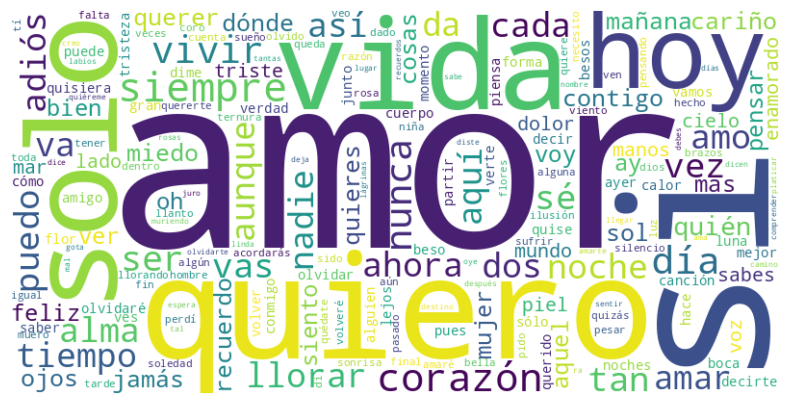

In [35]:
# Create global word cloud
def create_global_wordcloud():
    global_tfidf = tfidf_df.sum(axis=0)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(global_tfidf)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

create_global_wordcloud()

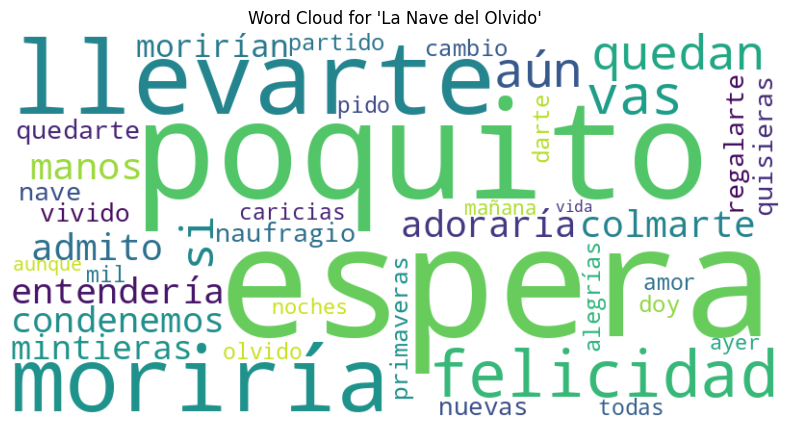

In [36]:
# Create word cloud for a specific song
def create_song_wordcloud(song_name):
    if song_name in tfidf_df.index:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_df.loc[song_name])
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for '{song_name}'")
        plt.show()

create_song_wordcloud('La Nave del Olvido')

# Section 3: BERT for Lyrics Embedding and Visualization

## Simple example

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
# Function to tokenize input and get embeddings
def get_bert_embeddings(sentence):
    # Truncate the input sequence to a maximum length of 512 tokens
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0].numpy()

# Example sentence - Tokenization and Embeddings
sentence = "This is fucking diabolical"
inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)

# Display Tokens and IDs
tokens_with_specials = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
token_ids = inputs['input_ids'][0].tolist()

print("Tokens with special tokens:", tokens_with_specials)
print("Token IDs:", token_ids)

# Get embeddings
embeddings = get_bert_embeddings(sentence)
print("Shape of embeddings:", embeddings.shape)

Tokens with special tokens: ['[CLS]', 'this', 'is', 'fucking', 'dia', '##bolic', '##al', '[SEP]']
Token IDs: [101, 2023, 2003, 8239, 22939, 18647, 2389, 102]
Shape of embeddings: (8, 768)


## BERT process

In [39]:
# Enable progress_apply for pandas Series
tqdm.pandas()

def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0].numpy()

df['Average Embedding'] = df['Lyrics'].progress_apply(lambda x: np.mean(get_bert_embeddings(x)[1:-1], axis=0))

average_embeddings_df = pd.DataFrame(df['Average Embedding'].to_list())
average_embeddings_df.head()

100%|██████████| 237/237 [04:08<00:00,  1.05s/it]
<ipython-input-39-7b8705c0419a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average Embedding'] = df['Lyrics'].progress_apply(lambda x: np.mean(get_bert_embeddings(x)[1:-1], axis=0))


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.357291,0.310179,0.215977,0.010505,0.411993,0.422795,0.286682,0.801953,0.159218,-0.204303,...,0.011269,-0.260310,0.273977,-0.067183,-0.050834,-0.512644,-0.021548,-0.381711,-0.129881,0.491948
1,-0.055953,0.254977,0.046839,0.272077,0.393392,0.820442,0.574744,0.964900,0.419168,-0.360067,...,0.285160,-0.430006,0.424480,0.073438,-0.355486,-0.289007,0.252356,-0.660017,-0.011067,0.750741
2,-0.425565,0.371702,0.134430,0.229907,0.451949,0.413017,0.260070,0.747463,0.199505,-0.218219,...,0.111468,-0.227276,0.340292,-0.231976,-0.079018,-0.395726,0.005577,-0.396122,-0.120616,0.586040
3,-0.528318,0.261447,0.218908,0.209851,0.378726,0.595749,0.456387,0.808484,0.156206,-0.112747,...,0.111204,-0.291453,0.213920,-0.096675,-0.250098,-0.523830,-0.184922,-0.454835,-0.013149,0.705614
4,-0.353524,0.377898,0.142204,0.067625,0.594828,0.730366,0.341960,0.890091,0.497270,-0.211749,...,0.221029,-0.430780,0.317836,-0.014433,-0.218378,-0.458598,-0.125227,-0.554561,-0.013431,0.674366


## t-SNE Visualization and Clustering

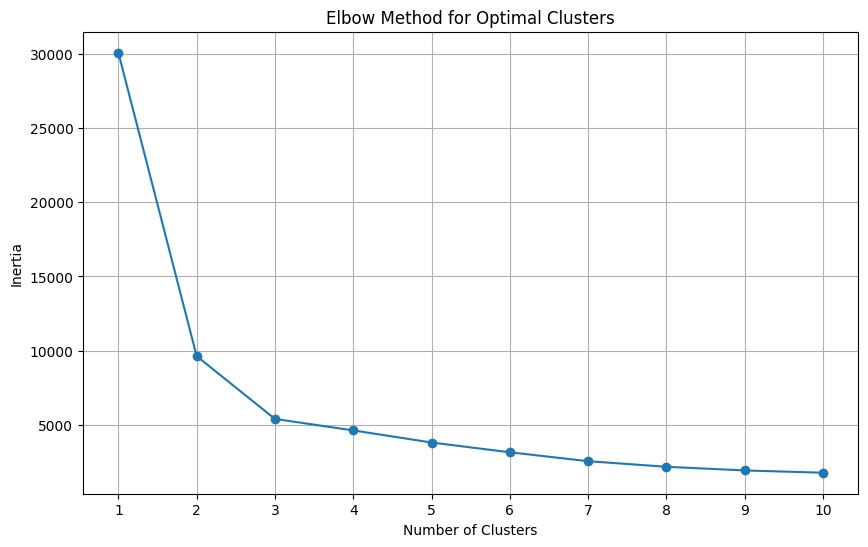

In [50]:
# Step 1: t-SNE Transformation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(average_embeddings_df)

# Step 2: Elbow Method to find optimal number of clusters
range_n_clusters = range(1, 11)  # Adjust this range as needed
inertia = []

# Calculate KMeans inertia for each number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings_2d)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()


In [51]:
# Step 1: Assign t-SNE results to DataFrame without warnings
df.loc[:, 'TSNE Dimension 1'] = embeddings_2d[:, 0]
df.loc[:, 'TSNE Dimension 2'] = embeddings_2d[:, 1]

# Step 2: KMeans Clustering with optimal number of clusters
num_clusters = 3  # Adjust based on elbow method results
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df.loc[:, 'Cluster'] = kmeans.fit_predict(embeddings_2d)

# Step 3: Scatter Plot with Hover
fig = px.scatter(
    df,
    x='TSNE Dimension 1',
    y='TSNE Dimension 2',
    color='Cluster',
    hover_name='Song Name',  # This line displays song names on hover
    title='t-SNE Visualization with KMeans Clustering'
)

# Show the plot
fig.show()